# Lane Damage Classification Project 

# 1. 데이터 확인 
    - 클래스별 이미지 개수 확인 
    - 랜덤으로 출력하여 이미지 데이터 확인

A: 220 images
B: 102 images
C: 94 images
D: 13 images


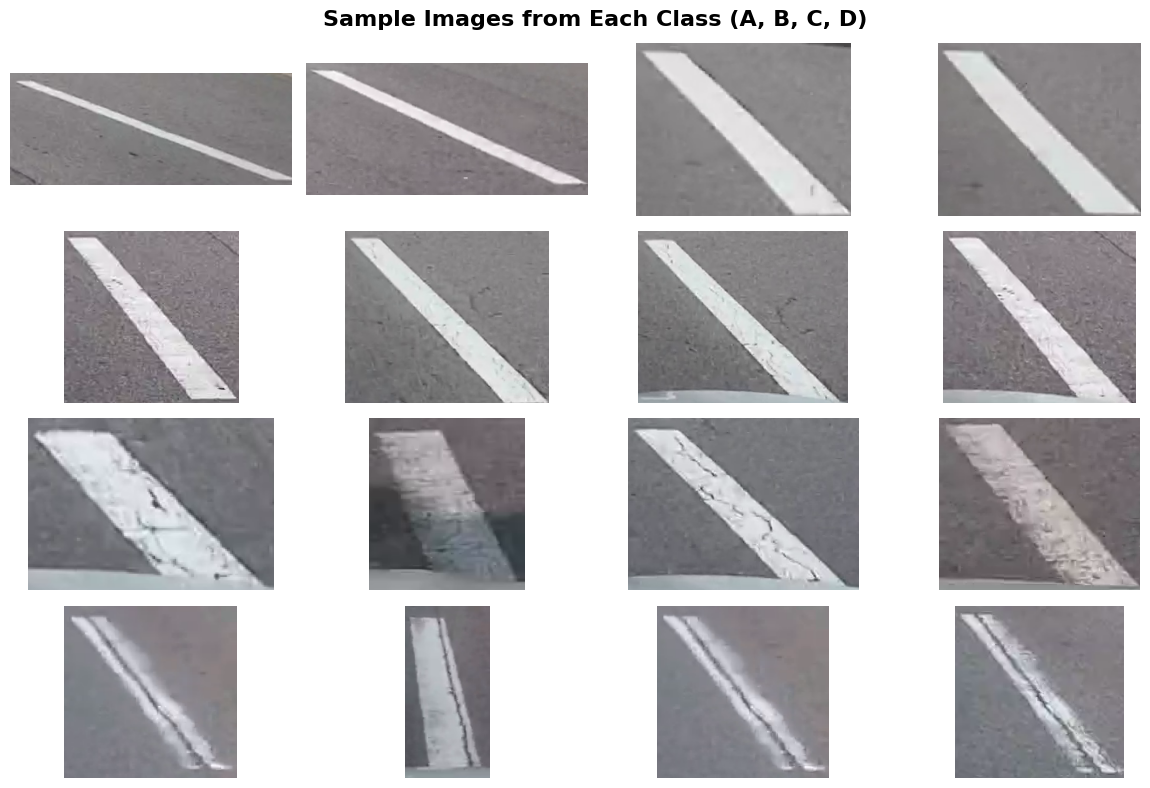

In [4]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

base_dir = "/home/a202520154/자동차 차선훼손/unzipped"
classes = ["A","B","C","D"]

# 클래스별 이미지 개수 출력
for cls in classes:
    folder = os.path.join(base_dir, cls, cls)
    count = len([f for f in os.listdir(folder) if f.lower().endswith(".png")])
    print(f"{cls}: {count} images")

# 클래스별 랜덤 4장 시각화
n_images = 4
plt.figure(figsize=(12,8))

for i, cls in enumerate(classes):
    folder = os.path.join(base_dir, cls, cls)
    images = [f for f in os.listdir(folder) if f.lower().endswith(".png")]
    selected = random.sample(images, min(len(images), n_images))

    for j, img_name in enumerate(selected):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path).convert("RGB")
        
        idx = i * n_images + j + 1
        plt.subplot(len(classes), n_images, idx)
        plt.imshow(img)
        plt.axis("off")

        # 행의 첫 번째 열에만 클래스 라벨 추가
        if j == 0:
            plt.ylabel(cls, fontsize=14, rotation=0, 
                       labelpad=30, weight="bold", va="center")

plt.suptitle("Sample Images from Each Class (A, B, C, D)", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()


- 데이터 불균형 문제 존재 → 추후 학습 시 데이터 증강 또는 가중치 조정 필요 

# 데이터셋 분할 

In [10]:
import os
import shutil
import random
from pathlib import Path

# 원본 경로
base_dir = Path("/home/a202520154/자동차 차선훼손/unzipped")
output_dir = Path("/home/a202520154/자동차 차선훼손/splitted")
splits = ["train", "val", "test"]

# 분할 비율
train_ratio, val_ratio = 0.7, 0.2

# 클래스 폴더
classes = ["A", "B", "C", "D"]

# 새 폴더 생성
for split in splits:
    for cls in classes:
        os.makedirs(output_dir / split / cls, exist_ok=True)

# 데이터 나누기
for cls in classes:
    src_folder = base_dir / cls / cls
    images = [f for f in os.listdir(src_folder) if f.lower().endswith(".png")]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(train_ratio * n_total)
    n_val   = int(val_ratio * n_total)

    train_files = images[:n_train]
    val_files   = images[n_train:n_train+n_val]
    test_files  = images[n_train+n_val:]

    for f in train_files:
        shutil.copy(src_folder / f, output_dir / "train" / cls / f)
    for f in val_files:
        shutil.copy(src_folder / f, output_dir / "val" / cls / f)
    for f in test_files:
        shutil.copy(src_folder / f, output_dir / "test" / cls / f)

    print(f"{cls}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

print("✅ 데이터셋 분할 완료!")


A: 154 train, 44 val, 22 test
B: 71 train, 20 val, 11 test
C: 65 train, 18 val, 11 test
D: 9 train, 2 val, 2 test
✅ 데이터셋 분할 완료!


# 데이터 전처리 
- 128x 128 리사이즈 

✅ 모든 이미지를 128x128로 리사이즈 후 splitted_resize에 저장 완료!


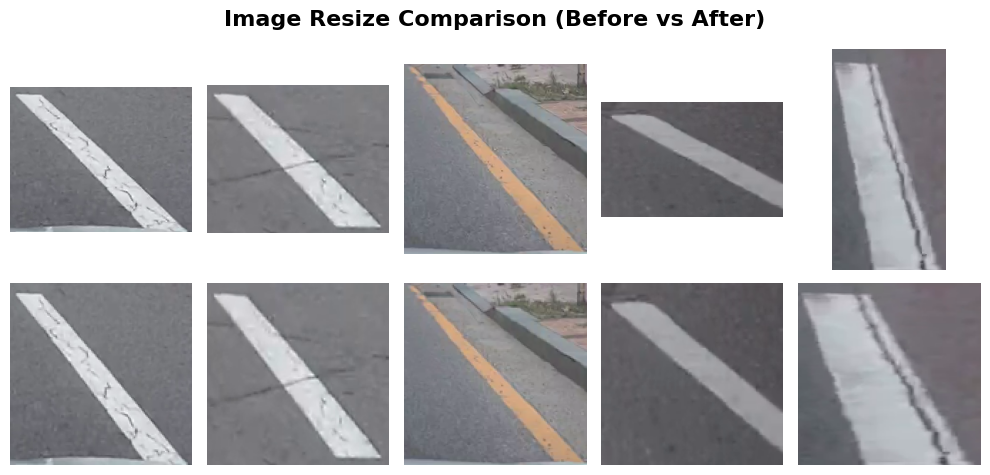

In [12]:
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import random

# 원본 데이터 경로
input_dir = Path("/home/a202520154/자동차 차선훼손/splitted")
# 리사이즈 후 저장 경로
output_dir = Path("/home/a202520154/자동차 차선훼손/splitted_resize")
splits = ["train", "val", "test"]
classes = ["A", "B", "C", "D"]

# 리사이즈 크기
resize_size = (128, 128)

# 새 폴더 구조 생성
for split in splits:
    for cls in classes:
        os.makedirs(output_dir / split / cls, exist_ok=True)

# 이미지 리사이즈 및 저장
for split in splits:
    for cls in classes:
        src_folder = input_dir / split / cls
        dst_folder = output_dir / split / cls
        for img_name in os.listdir(src_folder):
            if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                src_path = src_folder / img_name
                dst_path = dst_folder / img_name
                try:
                    img = Image.open(src_path).convert("RGB")
                    img_resized = img.resize(resize_size, Image.LANCZOS)
                    img_resized.save(dst_path)  # 새 폴더에 저장
                except Exception as e:
                    print(f"⚠️ {src_path} 처리 실패: {e}")

print("✅ 모든 이미지를 128x128로 리사이즈 후 splitted_resize에 저장 완료!")

# ============================================================
# 전/후 비교 (5개 무작위 선택)
# ============================================================
sample_images = []
for cls in classes:
    folder = input_dir / "train" / cls
    files = [f for f in os.listdir(folder) if f.lower().endswith(".png")]
    if files:
        sample_images.extend([folder / f for f in random.sample(files, min(2, len(files)))])  # 각 클래스에서 최대 2장
sample_images = random.sample(sample_images, min(5, len(sample_images)))

plt.figure(figsize=(10, 5))
for i, img_path in enumerate(sample_images):
    # 원본
    orig = Image.open(img_path).convert("RGB")
    # 리사이즈된 이미지
    resized_path = output_dir / img_path.relative_to(input_dir)
    resized = Image.open(resized_path).convert("RGB")

    # subplot (2행: 원본/리사이즈)
    plt.subplot(2, len(sample_images), i+1)
    plt.imshow(orig)
    plt.axis("off")
    if i == 0:
        plt.ylabel("Before", fontsize=12, weight="bold")

    plt.subplot(2, len(sample_images), i+1+len(sample_images))
    plt.imshow(resized)
    plt.axis("off")
    if i == 0:
        plt.ylabel("After", fontsize=12, weight="bold")

plt.suptitle("Image Resize Comparison (Before vs After)", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()


# CNN 모델
- 데이터 증강 + 클래스 가중치 ( 데이터 가중치 )

In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

# ============================================================
# 1. GPU 설정
# ============================================================
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print("사용 중인 디바이스:", device)

# ============================================================
# 2. 데이터 전처리 (증강 없음)
# ============================================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

base_dir = "/home/a202520154/자동차 차선훼손/splitted_resize"

train_dataset = datasets.ImageFolder(root=os.path.join(base_dir, "train"), transform=transform)
val_dataset   = datasets.ImageFolder(root=os.path.join(base_dir, "val"), transform=transform)
test_dataset  = datasets.ImageFolder(root=os.path.join(base_dir, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("클래스 매핑:", train_dataset.class_to_idx)

# ============================================================
# 3. 간단한 CNN 모델 정의
# ============================================================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),   # 64x64

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),   # 32x32

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)    # 16x16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*16*16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=4).to(device)

# ============================================================
# 4. 손실 함수 & 옵티마이저
# ============================================================
criterion = nn.CrossEntropyLoss()  # 가중치 없음
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ============================================================
# 5. 학습 루프
# ============================================================
EPOCHS = 20
for epoch in range(EPOCHS):
    # ----- Train -----
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100 * correct / total

    # ----- Validation -----
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

# ============================================================
# 6. Test 평가
# ============================================================
model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

print(f"최종 Test Accuracy: {100 * test_correct / test_total:.2f}%")


사용 중인 디바이스: cuda:2
클래스 매핑: {'A': 0, 'B': 1, 'C': 2, 'D': 3}


Epoch 1/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 23.02it/s]


Epoch [1/20] Train Loss: 1.1659, Train Acc: 41.81% | Val Loss: 1.0111, Val Acc: 67.86%


Epoch 2/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 23.29it/s]


Epoch [2/20] Train Loss: 1.0133, Train Acc: 55.52% | Val Loss: 0.7871, Val Acc: 75.00%


Epoch 3/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 23.20it/s]


Epoch [3/20] Train Loss: 0.7855, Train Acc: 68.56% | Val Loss: 0.6769, Val Acc: 73.81%


Epoch 4/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 22.88it/s]


Epoch [4/20] Train Loss: 0.6469, Train Acc: 78.26% | Val Loss: 0.4629, Val Acc: 79.76%


Epoch 5/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 23.38it/s]


Epoch [5/20] Train Loss: 0.5491, Train Acc: 79.26% | Val Loss: 0.4011, Val Acc: 89.29%


Epoch 6/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 23.40it/s]


Epoch [6/20] Train Loss: 0.3771, Train Acc: 85.95% | Val Loss: 0.2978, Val Acc: 86.90%


Epoch 7/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 23.40it/s]


Epoch [7/20] Train Loss: 0.3671, Train Acc: 85.62% | Val Loss: 0.3242, Val Acc: 85.71%


Epoch 8/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 23.37it/s]


Epoch [8/20] Train Loss: 0.3324, Train Acc: 87.96% | Val Loss: 0.2591, Val Acc: 86.90%


Epoch 9/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 23.15it/s]


Epoch [9/20] Train Loss: 0.3420, Train Acc: 88.96% | Val Loss: 0.2685, Val Acc: 89.29%


Epoch 10/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 23.30it/s]


Epoch [10/20] Train Loss: 0.3208, Train Acc: 85.28% | Val Loss: 0.2638, Val Acc: 86.90%


Epoch 11/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 23.37it/s]


Epoch [11/20] Train Loss: 0.3011, Train Acc: 90.30% | Val Loss: 0.2018, Val Acc: 89.29%


Epoch 12/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 23.39it/s]


Epoch [12/20] Train Loss: 0.2360, Train Acc: 88.29% | Val Loss: 0.1927, Val Acc: 90.48%


Epoch 13/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 23.26it/s]


Epoch [13/20] Train Loss: 0.2093, Train Acc: 90.30% | Val Loss: 0.1512, Val Acc: 94.05%


Epoch 14/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 21.16it/s]


Epoch [14/20] Train Loss: 0.1959, Train Acc: 90.97% | Val Loss: 0.2243, Val Acc: 88.10%


Epoch 15/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 20.37it/s]


Epoch [15/20] Train Loss: 0.1523, Train Acc: 93.31% | Val Loss: 0.1262, Val Acc: 94.05%


Epoch 16/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 20.41it/s]


Epoch [16/20] Train Loss: 0.1713, Train Acc: 94.65% | Val Loss: 0.1706, Val Acc: 92.86%


Epoch 17/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 22.51it/s]


Epoch [17/20] Train Loss: 0.1702, Train Acc: 92.31% | Val Loss: 0.1488, Val Acc: 95.24%


Epoch 18/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 22.52it/s]


Epoch [18/20] Train Loss: 0.1484, Train Acc: 93.98% | Val Loss: 0.1177, Val Acc: 92.86%


Epoch 19/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 22.51it/s]


Epoch [19/20] Train Loss: 0.1468, Train Acc: 95.99% | Val Loss: 0.1206, Val Acc: 94.05%


Epoch 20/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 21.08it/s]


Epoch [20/20] Train Loss: 0.1227, Train Acc: 96.66% | Val Loss: 0.1137, Val Acc: 95.24%
최종 Test Accuracy: 93.48%


In [16]:
# 모델 저장 경로
save_path = "/home/a202520154/자동차 차선훼손/simple_cnn_baseline.pth"

torch.save(model.state_dict(), save_path)
print(f"✅ 모델 저장 완료: {save_path}")


✅ 모델 저장 완료: /home/a202520154/자동차 차선훼손/simple_cnn_baseline.pth


# Test 예측 시각화

사용 중인 디바이스: cuda:2
클래스 매핑: {0: 'A', 1: 'B', 2: 'C', 3: 'D'}


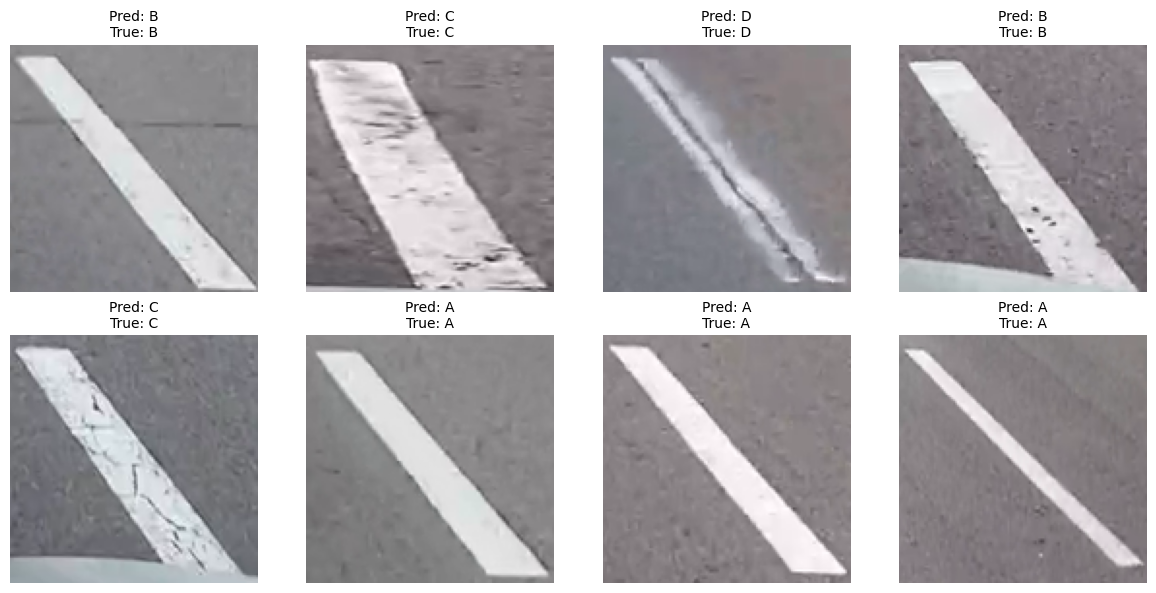

In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ============================================================
# 1. 환경 설정
# ============================================================
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print("사용 중인 디바이스:", device)

# 데이터 전처리 (test는 augmentation 없이)
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# 테스트 데이터셋 불러오기
test_dir = "/home/a202520154/자동차 차선훼손/splitted_resize/test"
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# 클래스 이름 (라벨 인덱스 → 클래스명)
idx_to_class = {v:k for k,v in test_dataset.class_to_idx.items()}
print("클래스 매핑:", idx_to_class)

# ============================================================
# 2. 모델 불러오기
# ============================================================
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),   # 64x64

            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),   # 32x32

            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2)    # 16x16
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(128*16*16, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 모델 로드
model = SimpleCNN(num_classes=4).to(device)
model.load_state_dict(torch.load("/home/a202520154/자동차 차선훼손/simple_cnn_baseline.pth", map_location=device))
model.eval()

# ============================================================
# 3. 시각화 예측 결과 확인
# ============================================================
def imshow(img):
    img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# 테스트 데이터에서 랜덤으로 8장 뽑아 시각화
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        if i >= 8:  # 8장만 시각화
            break
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        ax = axes[i//4, i%4]
        ax.imshow(imshow(images.cpu().squeeze()))
        ax.set_title(f"Pred: {idx_to_class[preds.item()]}\nTrue: {idx_to_class[labels.item()]}", fontsize=10)
        ax.axis("off")

plt.tight_layout()
plt.show()


# ResNet 18

In [19]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

# ============================================================
# 1. GPU 설정
# ============================================================
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print("사용 중인 디바이스:", device)

# ============================================================
# 2. 데이터 전처리
# ============================================================
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# ============================================================
# 3. 데이터셋 로드
# ============================================================
base_dir = "/home/a202520154/자동차 차선훼손/splitted_resize"

train_dataset = datasets.ImageFolder(root=os.path.join(base_dir, "train"), transform=train_transform)
val_dataset   = datasets.ImageFolder(root=os.path.join(base_dir, "val"), transform=val_test_transform)
test_dataset  = datasets.ImageFolder(root=os.path.join(base_dir, "test"), transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print("클래스 매핑:", train_dataset.class_to_idx)

# ============================================================
# 4. ResNet18 불러오기 & 수정
# ============================================================
model = models.resnet18(pretrained=True)  # 사전 학습된 가중치 불러오기
num_ftrs = model.fc.in_features           # 마지막 FC layer input size
model.fc = nn.Linear(num_ftrs, len(class_names))  # 출력 클래스 개수에 맞게 수정

model = model.to(device)

# ============================================================
# 5. 손실함수 & 옵티마이저
# ============================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# ============================================================
# 6. 학습 루프
# ============================================================
EPOCHS = 20
for epoch in range(EPOCHS):
    # ----- Train -----
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100 * correct / total

    # ----- Validation -----
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

# ============================================================
# 7. Test 평가
# ============================================================
model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

print(f"최종 Test Accuracy: {100 * test_correct / test_total:.2f}%")

# ============================================================
# 8. 모델 저장
# ============================================================
save_path = "/home/a202520154/자동차 차선훼손/resnet18_baseline.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ 모델 저장 완료: {save_path}")


사용 중인 디바이스: cuda:2
클래스 매핑: {'A': 0, 'B': 1, 'C': 2, 'D': 3}


Epoch 1/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 10.02it/s]


Epoch [1/20] Train Loss: 1.1579, Train Acc: 50.84% | Val Loss: 0.8351, Val Acc: 66.67%


Epoch 2/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.34it/s]


Epoch [2/20] Train Loss: 0.4404, Train Acc: 84.62% | Val Loss: 0.3837, Val Acc: 89.29%


Epoch 3/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.64it/s]


Epoch [3/20] Train Loss: 0.2294, Train Acc: 93.31% | Val Loss: 0.2054, Val Acc: 94.05%


Epoch 4/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.69it/s]


Epoch [4/20] Train Loss: 0.2136, Train Acc: 93.65% | Val Loss: 0.1469, Val Acc: 96.43%


Epoch 5/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.32it/s]


Epoch [5/20] Train Loss: 0.1437, Train Acc: 95.65% | Val Loss: 0.1405, Val Acc: 96.43%


Epoch 6/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.76it/s]


Epoch [6/20] Train Loss: 0.1116, Train Acc: 95.32% | Val Loss: 0.1811, Val Acc: 94.05%


Epoch 7/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.34it/s]


Epoch [7/20] Train Loss: 0.1632, Train Acc: 94.65% | Val Loss: 0.1278, Val Acc: 96.43%


Epoch 8/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.59it/s]


Epoch [8/20] Train Loss: 0.1484, Train Acc: 95.99% | Val Loss: 0.1048, Val Acc: 96.43%


Epoch 9/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.56it/s]


Epoch [9/20] Train Loss: 0.1199, Train Acc: 95.65% | Val Loss: 0.1360, Val Acc: 95.24%


Epoch 10/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.12it/s]


Epoch [10/20] Train Loss: 0.0734, Train Acc: 98.33% | Val Loss: 0.1084, Val Acc: 97.62%


Epoch 11/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.25it/s]


Epoch [11/20] Train Loss: 0.1387, Train Acc: 97.66% | Val Loss: 0.1331, Val Acc: 96.43%


Epoch 12/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.33it/s]


Epoch [12/20] Train Loss: 0.0995, Train Acc: 96.32% | Val Loss: 0.1248, Val Acc: 95.24%


Epoch 13/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.31it/s]


Epoch [13/20] Train Loss: 0.0979, Train Acc: 95.32% | Val Loss: 0.1341, Val Acc: 92.86%


Epoch 14/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.83it/s]


Epoch [14/20] Train Loss: 0.0823, Train Acc: 97.99% | Val Loss: 0.0932, Val Acc: 94.05%


Epoch 15/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 12.01it/s]


Epoch [15/20] Train Loss: 0.0938, Train Acc: 97.32% | Val Loss: 0.1240, Val Acc: 95.24%


Epoch 16/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.95it/s]


Epoch [16/20] Train Loss: 0.1177, Train Acc: 95.65% | Val Loss: 0.1130, Val Acc: 95.24%


Epoch 17/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 10.00it/s]


Epoch [17/20] Train Loss: 0.0669, Train Acc: 97.66% | Val Loss: 0.1379, Val Acc: 95.24%


Epoch 18/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.65it/s]


Epoch [18/20] Train Loss: 0.0548, Train Acc: 97.99% | Val Loss: 0.1122, Val Acc: 96.43%


Epoch 19/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.19it/s]


Epoch [19/20] Train Loss: 0.0243, Train Acc: 99.67% | Val Loss: 0.1062, Val Acc: 96.43%


Epoch 20/20 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.62it/s]


Epoch [20/20] Train Loss: 0.0310, Train Acc: 98.33% | Val Loss: 0.0834, Val Acc: 96.43%
최종 Test Accuracy: 95.65%
✅ 모델 저장 완료: /home/a202520154/자동차 차선훼손/resnet18_baseline.pth


# ResNet 18 Test이미지 시각화 

클래스 매핑: {'A': 0, 'B': 1, 'C': 2, 'D': 3}


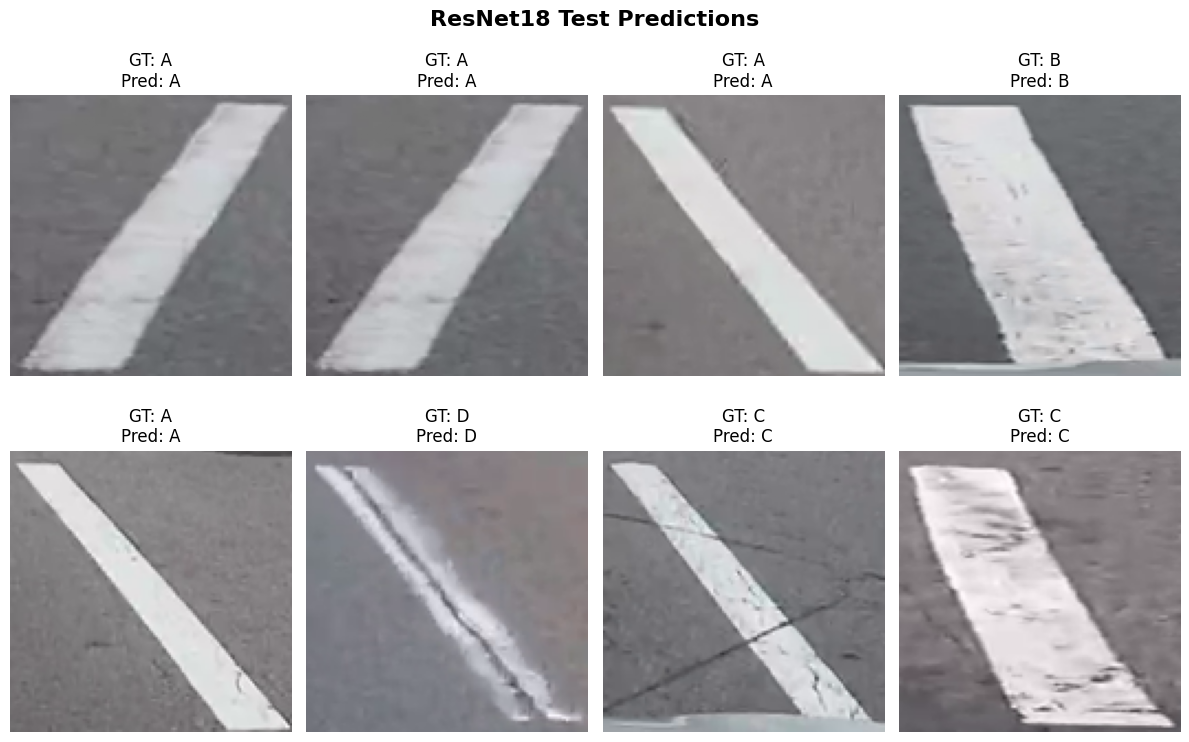

In [20]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# ============================================================
# 1. GPU 설정
# ============================================================
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# ============================================================
# 2. 데이터셋 로드 (val/test transform 동일하게 적용)
# ============================================================
val_test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

base_dir = "/home/a202520154/자동차 차선훼손/splitted_resize"
test_dataset  = datasets.ImageFolder(root=os.path.join(base_dir, "test"), transform=val_test_transform)
test_loader   = DataLoader(test_dataset, batch_size=16, shuffle=True)

class_names = test_dataset.classes
print("클래스 매핑:", test_dataset.class_to_idx)

# ============================================================
# 3. ResNet18 모델 불러오기
# ============================================================
model = models.resnet18(pretrained=False)   # 저장된 모델 불러오기 (pretrained 필요 없음)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load("/home/a202520154/자동차 차선훼손/resnet18_baseline.pth", map_location=device))
model = model.to(device)
model.eval()

# ============================================================
# 4. 시각화 함수
# ============================================================
def imshow(inp, title=None):
    """Tensor -> 이미지 시각화"""
    inp = inp.cpu().numpy().transpose((1, 2, 0))  # CHW -> HWC
    inp = inp * 0.5 + 0.5  # Normalize 역변환 (mean=0.5, std=0.5)
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis("off")

# ============================================================
# 5. Test 이미지 예측 & 시각화
# ============================================================
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12, 8))
for i in range(min(8, len(images))):  # 8개만 보여주기
    plt.subplot(2, 4, i+1)
    imshow(images[i], title=f"GT: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")

plt.suptitle("ResNet18 Test Predictions", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()
